<a href="https://colab.research.google.com/github/xascendent/AIEcolab/blob/main/Advanced_Retrieval_with_LangChain_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally.

In [1]:
!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.7 MB/s eta 0:00:00


We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [2]:
!pip install -qU qdrant-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 17.4 MB/s eta 0:00:00


We'll also provide our OpenAI key, as well as our Cohere API key.

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

Enter your OpenAI API Key:··········


In [4]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

Cohere API Key:··········


## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [5]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-03-03 15:14:41--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.001s  

2025-03-03 15:14:41 (24.8 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-03-03 15:14:41--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text/plain]
Sa

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [6]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [7]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 2, 28, 15, 14, 47, 367408)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [8]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [9]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [10]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [11]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [12]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [13]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided. It was described as a cool, stylish, and exciting action film that received high ratings from critics and audiences.'

In [14]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for "John Wick 3". Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\'.'

In [15]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is a movie about an ex-hitman who comes out of retirement to seek vengeance against the gangsters that killed his dog and took everything from him. The story is filled with violent action, shootouts, and breathtaking fights.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [16]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [17]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [18]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"While opinions may vary, based on the reviews provided, it seems that John Wick received mixed feedback. Some people really enjoyed the movie, appreciating its action sequences and unique premise, but others found it lacking in plot and substance. So, it's safe to say that not everyone necessarily liked John Wick."

In [19]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I don't know if any reviews have a rating of 10."

In [20]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the main character, played by Keanu Reeves, finds himself embroiled in a quest for vengeance after his dog, a gift from his deceased wife, is killed. This sets off a chain of events that leads to intense action sequences and showcases his incredible skills as a former assassin. The movie is praised for its well-choreographed action scenes and emotional depth within the action genre.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [21]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [22]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [23]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, it seems like people generally liked the first John Wick movie. The reviewers praised Keanu Reeves' performance, the action sequences, and the overall style of the film. One reviewer even mentioned that it was the best action film of the year. As for the third John Wick movie, one reviewer seemed to think that the magic of the first film was gone."

In [24]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n- URL: https://www.imdb.com/review/rw4854296/?ref_=tt_urv'

In [25]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, the main character, played by Keanu Reeves, is forced back into the world of assassins after a crime lord destroys his home and asks for his help. Wick is then tasked with killing a mobster's sister in Rome in order for the mobster to ascend in the criminal organization. Wick completes the mission but then has a contract put on his life. The plot follows Wick seeking revenge and dealing with the consequences of his actions."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [26]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [27]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [28]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Overall, people seemed to really enjoy the John Wick movies. The reviews are generally positive, with comments such as "the coolest action film you\'ll see all year," "smoothest action film to come around in a long time," and "kinetic, concise, and stylish." There are some negative reviews, but they appear to be outliers compared to the overwhelmingly positive reception.'

In [29]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n- Review URL: /review/rw4854296/?ref_=tt_urv\n\nIf you need any more assistance, feel free to ask!'

In [30]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick movies, the protagonist, John Wick, is a retired hitman who seeks revenge after his dog is killed and his car is stolen by Russian gangsters. This sets off a series of violent events where John Wick goes on a killing spree to avenge his losses.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [31]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [32]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

<ipython-input-32-4887b10d4438>:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [33]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [34]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [35]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [36]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Overall, opinions on John Wick seem to vary. Some people love the series and find it consistent and well-received, while others have criticized certain aspects like the plot and fight scenes. So, it's safe to say that people have mixed feelings about John Wick."

In [37]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\nhttps://www.imdb.com//review/rw4854296/?ref_=tt_urv'

In [38]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, a retired assassin named John Wick comes out of retirement after someone kills his dog and steals his car. He goes on a rampage of revenge and is later forced to pay off an old debt by helping take over the Assassin's Guild. John travels to Italy, Canada, and Manhattan, killing numerous assassins along the way."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [39]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [40]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [41]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, it seems like the majority of people really liked the John Wick movies, especially the first one. The reviews praise the action sequences, Keanu Reeves' performance, and the overall entertainment value of the films. The consensus appears to be that John Wick was well-received by audiences."

In [42]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3." Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\'.'

In [43]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie "John Wick," an ex-hitman comes out of retirement to seek vengeance after gangsters kill his dog and take everything from him. The story is filled with lots of violence, action-packed shootouts, and breathtaking fights as John Wick goes on a relentless quest for retribution. It\'s a gripping and intense story of revenge and survival.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [44]:
!pip install -qU langchain_experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 3.7 MB/s eta 0:00:00


We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [45]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [46]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [47]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [48]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [49]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [50]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, it seems that the majority of people did enjoy the John Wick movies.'

In [51]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3." Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\'.'

In [52]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the main character seeks revenge on the people who took something he loved from him, which sets off a chain of violent and action-packed events.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [53]:
!pip install -qU ragas==0.2.10 unstructured==0.16.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.0 MB/s eta 0:00:00
   

In [54]:
os.environ["RAGAS_APP_TOKEN"] = getpass.getpass("Please enter your Ragas API key!")

Please enter your Ragas API key!··········


In [55]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [56]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(movie_docs, testset_size=10)

Applying SummaryExtractor:   0%|          | 0/12 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/25 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/62 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [57]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,"So, like, what The Marquis do in the John Wick...","[: 1\nReview: The Table, the international crm...","The Marquis is empowered by The Table, the int...",single_hop_specifc_query_synthesizer
1,Why John Wick movies too much action?,[: 2\nReview: The first three John Wick films ...,The first three John Wick films came in fairly...,single_hop_specifc_query_synthesizer
2,What are the reviews saying about the latest J...,[: 3\nReview: These John Wick movies can be so...,The review suggests that the latest John Wick ...,single_hop_specifc_query_synthesizer
3,What happened to the franchise after Parabellu...,[: 4\nReview: I went to the cinema with great ...,"After 'Parabellum,' the franchise seemed to lo...",single_hop_specifc_query_synthesizer
4,What is the critical reception of the fourth i...,[: 6\nReview: In this fourth installment of 87...,In this fourth installment of 8711's successfu...,single_hop_specifc_query_synthesizer
5,How do the reviews of 'John Wick: Chapter 4' d...,[<1-hop>\n\n: 20\nReview: In a world where mov...,The reviews of 'John Wick: Chapter 4' differ s...,multi_hop_specific_query_synthesizer
6,How does Keanu Reeves' performance in the four...,[<1-hop>\n\n: 6\nReview: In this fourth instal...,Keanu Reeves' performance in the fourth instal...,multi_hop_specific_query_synthesizer
7,How does John Wick: Chapter 4 compare to the e...,[<1-hop>\n\n: 4\nReview: I went to the cinema ...,John Wick: Chapter 4 is criticized for losing ...,multi_hop_specific_query_synthesizer
8,How does the reception of 'John Wick: Chapter ...,[<1-hop>\n\n: 22\nReview: HORRIBLE movie. I lo...,The reception of 'John Wick: Chapter 4' appear...,multi_hop_specific_query_synthesizer
9,How has Chad Stahelski's direction influenced ...,[<1-hop>\n\n: 17\nReview: Stuntman turned writ...,"Chad Stahelski, originally a stuntman turned w...",multi_hop_specific_query_synthesizer


In [58]:
dataset.upload()

Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/3093cd8f-0d71-4c84-8ca2-0715e24e0a9d


'https://app.ragas.io/dashboard/alignment/testset/3093cd8f-0d71-4c84-8ca2-0715e24e0a9d'

In [59]:
# RAGAS SETUP
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))


In [60]:
def create_retriever_test_set(retriever, dataset):
  for test_row in dataset:
    response = retriever.invoke({"question" : test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"].content
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
  return dataset

In [61]:
from ragas import EvaluationDataset

def create_ragas_eval_dataset(dataset):
  evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())
  return evaluation_dataset

In [62]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

def perform_ragas_eval(evaluation_dataset, run_config=custom_run_config):
  result = evaluate(
      dataset=evaluation_dataset,
      metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
      llm=evaluator_llm,
      run_config=custom_run_config
  )
  return result

In [63]:
test_set = create_retriever_test_set(naive_retrieval_chain, dataset)

In [64]:
test_set.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,"So, like, what The Marquis do in the John Wick...","[: 1\nReview: The Table, the international crm...","[: 1\nReview: The Table, the international crm...","The Marquis is empowered by The Table, which i...","The Marquis is empowered by The Table, the int...",single_hop_specifc_query_synthesizer
1,Why John Wick movies too much action?,[: 2\nReview: The first three John Wick films ...,[: 2\nReview: The first three John Wick films ...,The John Wick movies are criticized by some fo...,The first three John Wick films came in fairly...,single_hop_specifc_query_synthesizer
2,What are the reviews saying about the latest J...,"[: 9\nReview: At first glance, John Wick sound...",[: 3\nReview: These John Wick movies can be so...,"The reviews for the latest John Wick movie, as...",The review suggests that the latest John Wick ...,single_hop_specifc_query_synthesizer
3,What happened to the franchise after Parabellu...,[: 4\nReview: I went to the cinema with great ...,[: 4\nReview: I went to the cinema with great ...,"After the movie ""Parabellum"" and subsequent en...","After 'Parabellum,' the franchise seemed to lo...",single_hop_specifc_query_synthesizer
4,What is the critical reception of the fourth i...,[: 6\nReview: In this fourth installment of 87...,[: 6\nReview: In this fourth installment of 87...,The critical reception of the fourth installme...,In this fourth installment of 8711's successfu...,single_hop_specifc_query_synthesizer
5,How do the reviews of 'John Wick: Chapter 4' d...,[: 24\nReview: John Wick: Chapter 4 is almost ...,[<1-hop>\n\n: 20\nReview: In a world where mov...,The reviews of 'John Wick: Chapter 4' vary gre...,The reviews of 'John Wick: Chapter 4' differ s...,multi_hop_specific_query_synthesizer
6,How does Keanu Reeves' performance in the four...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\n: 6\nReview: In this fourth instal...,"Based on the provided context, Keanu Reeves' p...",Keanu Reeves' performance in the fourth instal...,multi_hop_specific_query_synthesizer
7,How does John Wick: Chapter 4 compare to the e...,[: 19\nReview: John Wick: Chapter 4 picks up w...,[<1-hop>\n\n: 4\nReview: I went to the cinema ...,"Based on the reviews provided, it seems that J...",John Wick: Chapter 4 is criticized for losing ...,multi_hop_specific_query_synthesizer
8,How does the reception of 'John Wick: Chapter ...,[: 20\nReview: In a world where movie sequels ...,[<1-hop>\n\n: 22\nReview: HORRIBLE movie. I lo...,"Based on the reviews provided, the reception o...",The reception of 'John Wick: Chapter 4' appear...,multi_hop_specific_query_synthesizer
9,How has Chad Stahelski's direction influenced ...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\n: 17\nReview: Stuntman turned writ...,Chad Stahelski's direction has had a significa...,"Chad Stahelski, originally a stuntman turned w...",multi_hop_specific_query_synthesizer


In [65]:
evaluation_dataset = create_ragas_eval_dataset(test_set)

In [66]:
result = perform_ragas_eval(evaluation_dataset)
result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[18]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKGHy on tokens per min (TPM): Limit 30000, Used 29757, Requested 2525. Please try again in 4.564s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[28]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKGHy on tokens per min (TPM): Limit 30000, Used 29265, Requested 2274. Please try again in 3.078s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[25]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkM

{'context_recall': 0.7667, 'faithfulness': 0.5264, 'factual_correctness': 0.3840, 'answer_relevancy': 0.8375, 'context_entity_recall': 0.5264, 'noise_sensitivity_relevant': 0.1000}

In [67]:
# BM25 RAG CHAIN
test_set = create_retriever_test_set(bm25_retrieval_chain, dataset)

In [68]:
test_set.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,"So, like, what The Marquis do in the John Wick...",[: 4\nReview: I went to the cinema with great ...,"[: 1\nReview: The Table, the international crm...","Sorry, I don't know the details about what The...","The Marquis is empowered by The Table, the int...",single_hop_specifc_query_synthesizer
1,Why John Wick movies too much action?,[: 16\nReview: John Wick 3 is without a doubt ...,[: 2\nReview: The first three John Wick films ...,The John Wick movies have a lot of action beca...,The first three John Wick films came in fairly...,single_hop_specifc_query_synthesizer
2,What are the reviews saying about the latest J...,[: 8\nReview: It's hard to find anything bad t...,[: 3\nReview: These John Wick movies can be so...,The reviews of the latest John Wick movie vary...,The review suggests that the latest John Wick ...,single_hop_specifc_query_synthesizer
3,What happened to the franchise after Parabellu...,[: 14\nReview: By now you know what to expect ...,[: 4\nReview: I went to the cinema with great ...,The franchise lost its identity after Parabell...,"After 'Parabellum,' the franchise seemed to lo...",single_hop_specifc_query_synthesizer
4,What is the critical reception of the fourth i...,[: 6\nReview: In this fourth installment of 87...,[: 6\nReview: In this fourth installment of 87...,The critical reception of the fourth installme...,In this fourth installment of 8711's successfu...,single_hop_specifc_query_synthesizer
5,How do the reviews of 'John Wick: Chapter 4' d...,[: 20\nReview: In a world where movie sequels ...,[<1-hop>\n\n: 20\nReview: In a world where mov...,The reviews of 'John Wick: Chapter 4' differ i...,The reviews of 'John Wick: Chapter 4' differ s...,multi_hop_specific_query_synthesizer
6,How does Keanu Reeves' performance in the four...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\n: 6\nReview: In this fourth instal...,Keanu Reeves' performance in the fourth instal...,Keanu Reeves' performance in the fourth instal...,multi_hop_specific_query_synthesizer
7,How does John Wick: Chapter 4 compare to the e...,[: 19\nReview: John Wick: Chapter 4 picks up w...,[<1-hop>\n\n: 4\nReview: I went to the cinema ...,"Based on the review provided, John Wick: Chapt...",John Wick: Chapter 4 is criticized for losing ...,multi_hop_specific_query_synthesizer
8,How does the reception of 'John Wick: Chapter ...,[: 20\nReview: In a world where movie sequels ...,[<1-hop>\n\n: 22\nReview: HORRIBLE movie. I lo...,"Based on the reviews provided, 'John Wick: Cha...",The reception of 'John Wick: Chapter 4' appear...,multi_hop_specific_query_synthesizer
9,How has Chad Stahelski's direction influenced ...,[: 19\nReview: John Wick: Chapter 4 picks up w...,[<1-hop>\n\n: 17\nReview: Stuntman turned writ...,Chad Stahelski's direction has had a significa...,"Chad Stahelski, originally a stuntman turned w...",multi_hop_specific_query_synthesizer


In [69]:
evaluation_dataset = create_ragas_eval_dataset(test_set)

In [70]:
result = perform_ragas_eval(evaluation_dataset)
result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[22]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKGHy on tokens per min (TPM): Limit 30000, Used 29557, Requested 1603. Please try again in 2.32s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[7]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKGHy on tokens per min (TPM): Limit 30000, Used 29860, Requested 1554. Please try again in 2.828s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[30]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKG

{'context_recall': 0.4222, 'faithfulness': 0.7854, 'factual_correctness': 0.3070, 'answer_relevancy': 0.7676, 'context_entity_recall': 0.5380, 'noise_sensitivity_relevant': 0.2519}

In [71]:
# Contextual Compression - Reranking RAG Chain
test_set = create_retriever_test_set(contextual_compression_retrieval_chain, dataset)

In [72]:
test_set.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,"So, like, what The Marquis do in the John Wick...","[: 1\nReview: The Table, the international crm...","[: 1\nReview: The Table, the international crm...",The Marquis in the John Wick movie is a charac...,"The Marquis is empowered by The Table, the int...",single_hop_specifc_query_synthesizer
1,Why John Wick movies too much action?,[: 2\nReview: The first three John Wick films ...,[: 2\nReview: The first three John Wick films ...,John Wick movies have a lot of action because ...,The first three John Wick films came in fairly...,single_hop_specifc_query_synthesizer
2,What are the reviews saying about the latest J...,[: 8\nReview: It's hard to find anything bad t...,[: 3\nReview: These John Wick movies can be so...,The reviews for the latest John Wick movie are...,The review suggests that the latest John Wick ...,single_hop_specifc_query_synthesizer
3,What happened to the franchise after Parabellu...,[: 4\nReview: I went to the cinema with great ...,[: 4\nReview: I went to the cinema with great ...,"After ""Parabellum,"" some viewers feel that the...","After 'Parabellum,' the franchise seemed to lo...",single_hop_specifc_query_synthesizer
4,What is the critical reception of the fourth i...,[: 6\nReview: In this fourth installment of 87...,[: 6\nReview: In this fourth installment of 87...,The critical reception of the fourth installme...,In this fourth installment of 8711's successfu...,single_hop_specifc_query_synthesizer
5,How do the reviews of 'John Wick: Chapter 4' d...,[: 24\nReview: John Wick: Chapter 4 is almost ...,[<1-hop>\n\n: 20\nReview: In a world where mov...,The reviews of 'John Wick: Chapter 4' differ i...,The reviews of 'John Wick: Chapter 4' differ s...,multi_hop_specific_query_synthesizer
6,How does Keanu Reeves' performance in the four...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\n: 6\nReview: In this fourth instal...,Keanu Reeves' performance in the fourth instal...,Keanu Reeves' performance in the fourth instal...,multi_hop_specific_query_synthesizer
7,How does John Wick: Chapter 4 compare to the e...,[: 19\nReview: John Wick: Chapter 4 picks up w...,[<1-hop>\n\n: 4\nReview: I went to the cinema ...,"Based on the reviews provided, John Wick: Chap...",John Wick: Chapter 4 is criticized for losing ...,multi_hop_specific_query_synthesizer
8,How does the reception of 'John Wick: Chapter ...,[: 20\nReview: In a world where movie sequels ...,[<1-hop>\n\n: 22\nReview: HORRIBLE movie. I lo...,"Based on the reviews provided, the reception o...",The reception of 'John Wick: Chapter 4' appear...,multi_hop_specific_query_synthesizer
9,How has Chad Stahelski's direction influenced ...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\n: 17\nReview: Stuntman turned writ...,Chad Stahelski's direction has significantly i...,"Chad Stahelski, originally a stuntman turned w...",multi_hop_specific_query_synthesizer


In [73]:
evaluation_dataset = create_ragas_eval_dataset(test_set)

In [74]:
reranking_eval_result = perform_ragas_eval(evaluation_dataset)
reranking_eval_result  #Contextual Compression - Reranking RAG Chain

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[1]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKGHy on tokens per min (TPM): Limit 30000, Used 29621, Requested 1719. Please try again in 2.68s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[24]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKGHy on tokens per min (TPM): Limit 30000, Used 29519, Requested 1582. Please try again in 2.202s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[19]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKG

{'context_recall': 0.7143, 'faithfulness': 0.8487, 'factual_correctness': 0.3390, 'answer_relevancy': 0.8447, 'context_entity_recall': 0.5992, 'noise_sensitivity_relevant': 0.3242}

In [75]:
# Multi-Query Retriever
test_set = create_retriever_test_set(multi_query_retrieval_chain, dataset)

In [76]:
test_set.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,"So, like, what The Marquis do in the John Wick...","[: 1\nReview: The Table, the international crm...","[: 1\nReview: The Table, the international crm...","In the John Wick movie, The Marquis is empower...","The Marquis is empowered by The Table, the int...",single_hop_specifc_query_synthesizer
1,Why John Wick movies too much action?,[: 3\nReview: John wick has a very simple reve...,[: 2\nReview: The first three John Wick films ...,John Wick movies have a lot of action because ...,The first three John Wick films came in fairly...,single_hop_specifc_query_synthesizer
2,What are the reviews saying about the latest J...,"[: 9\nReview: At first glance, John Wick sound...",[: 3\nReview: These John Wick movies can be so...,The reviews for the latest John Wick movie in ...,The review suggests that the latest John Wick ...,single_hop_specifc_query_synthesizer
3,What happened to the franchise after Parabellu...,[: 4\nReview: I went to the cinema with great ...,[: 4\nReview: I went to the cinema with great ...,"After the movie ""Parabellum,"" some reviewers f...","After 'Parabellum,' the franchise seemed to lo...",single_hop_specifc_query_synthesizer
4,What is the critical reception of the fourth i...,[: 6\nReview: In this fourth installment of 87...,[: 6\nReview: In this fourth installment of 87...,The critical reception of the fourth installme...,In this fourth installment of 8711's successfu...,single_hop_specifc_query_synthesizer
5,How do the reviews of 'John Wick: Chapter 4' d...,[: 19\nReview: John Wick: Chapter 4 picks up w...,[<1-hop>\n\n: 20\nReview: In a world where mov...,The reviews of 'John Wick: Chapter 4' differ s...,The reviews of 'John Wick: Chapter 4' differ s...,multi_hop_specific_query_synthesizer
6,How does Keanu Reeves' performance in the four...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\n: 6\nReview: In this fourth instal...,Keanu Reeves' performance in the fourth instal...,Keanu Reeves' performance in the fourth instal...,multi_hop_specific_query_synthesizer
7,How does John Wick: Chapter 4 compare to the e...,[: 19\nReview: John Wick: Chapter 4 picks up w...,[<1-hop>\n\n: 4\nReview: I went to the cinema ...,"Based on the reviews provided, John Wick: Chap...",John Wick: Chapter 4 is criticized for losing ...,multi_hop_specific_query_synthesizer
8,How does the reception of 'John Wick: Chapter ...,[: 20\nReview: In a world where movie sequels ...,[<1-hop>\n\n: 22\nReview: HORRIBLE movie. I lo...,"Based on the reviews provided, the reception o...",The reception of 'John Wick: Chapter 4' appear...,multi_hop_specific_query_synthesizer
9,How has Chad Stahelski's direction influenced ...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\n: 17\nReview: Stuntman turned writ...,Chad Stahelski's direction has had a significa...,"Chad Stahelski, originally a stuntman turned w...",multi_hop_specific_query_synthesizer


In [77]:
evaluation_dataset = create_ragas_eval_dataset(test_set)

In [78]:
multiq_eval_result = perform_ragas_eval(evaluation_dataset)
multiq_eval_result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[18]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKGHy on tokens per min (TPM): Limit 30000, Used 29519, Requested 2973. Please try again in 4.984s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[22]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKGHy on tokens per min (TPM): Limit 30000, Used 29654, Requested 2562. Please try again in 4.432s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[4]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMK

{'context_recall': 0.7333, 'faithfulness': 0.6667, 'factual_correctness': 0.3267, 'answer_relevancy': 0.9385, 'context_entity_recall': 0.5062, 'noise_sensitivity_relevant': 0.1429}

In [79]:
# Parent Document Retriever
test_set = create_retriever_test_set(parent_document_retrieval_chain, dataset)

In [80]:
test_set.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,"So, like, what The Marquis do in the John Wick...","[: 1\nReview: The Table, the international crm...","[: 1\nReview: The Table, the international crm...","In the John Wick movie, The Marquis is empower...","The Marquis is empowered by The Table, the int...",single_hop_specifc_query_synthesizer
1,Why John Wick movies too much action?,[: 8\nReview: It's hard to find anything bad t...,[: 2\nReview: The first three John Wick films ...,The John Wick movies have a lot of action beca...,The first three John Wick films came in fairly...,single_hop_specifc_query_synthesizer
2,What are the reviews saying about the latest J...,[: 8\nReview: It's hard to find anything bad t...,[: 3\nReview: These John Wick movies can be so...,The reviews for the latest John Wick movie pra...,The review suggests that the latest John Wick ...,single_hop_specifc_query_synthesizer
3,What happened to the franchise after Parabellu...,[: 4\nReview: I went to the cinema with great ...,[: 4\nReview: I went to the cinema with great ...,"After the movie ""Parabellum,"" some viewers fel...","After 'Parabellum,' the franchise seemed to lo...",single_hop_specifc_query_synthesizer
4,What is the critical reception of the fourth i...,[: 6\nReview: In this fourth installment of 87...,[: 6\nReview: In this fourth installment of 87...,"Based on the review provided, the critical rec...",In this fourth installment of 8711's successfu...,single_hop_specifc_query_synthesizer
5,How do the reviews of 'John Wick: Chapter 4' d...,[: 19\nReview: John Wick: Chapter 4 picks up w...,[<1-hop>\n\n: 20\nReview: In a world where mov...,The reviews of 'John Wick: Chapter 4' differ i...,The reviews of 'John Wick: Chapter 4' differ s...,multi_hop_specific_query_synthesizer
6,How does Keanu Reeves' performance in the four...,[: 17\nReview: Stuntman turned writer/director...,[<1-hop>\n\n: 6\nReview: In this fourth instal...,Keanu Reeves' performance in the fourth instal...,Keanu Reeves' performance in the fourth instal...,multi_hop_specific_query_synthesizer
7,How does John Wick: Chapter 4 compare to the e...,[: 24\nReview: John Wick: Chapter 4 is almost ...,[<1-hop>\n\n: 4\nReview: I went to the cinema ...,"Based on the reviews provided, it seems there ...",John Wick: Chapter 4 is criticized for losing ...,multi_hop_specific_query_synthesizer
8,How does the reception of 'John Wick: Chapter ...,[: 19\nReview: John Wick: Chapter 4 picks up w...,[<1-hop>\n\n: 22\nReview: HORRIBLE movie. I lo...,"Based on the reviews provided, the reception o...",The reception of 'John Wick: Chapter 4' appear...,multi_hop_specific_query_synthesizer
9,How has Chad Stahelski's direction influenced ...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\n: 17\nReview: Stuntman turned writ...,Chad Stahelski's direction has greatly influen...,"Chad Stahelski, originally a stuntman turned w...",multi_hop_specific_query_synthesizer


In [81]:
evaluation_dataset = create_ragas_eval_dataset(test_set)

In [82]:
parentdoc_eval_result = perform_ragas_eval(evaluation_dataset)
parentdoc_eval_result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[26]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKGHy on tokens per min (TPM): Limit 30000, Used 29510, Requested 1604. Please try again in 2.228s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[8]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKGHy on tokens per min (TPM): Limit 30000, Used 29856, Requested 1550. Please try again in 2.812s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[2]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKG

{'context_recall': 0.5111, 'faithfulness': 0.8672, 'factual_correctness': 0.2350, 'answer_relevancy': 0.8482, 'context_entity_recall': 0.5708, 'noise_sensitivity_relevant': 0.2718}

In [83]:
# Ensemble Retriever
test_set = create_retriever_test_set(ensemble_retrieval_chain, dataset)

In [84]:
test_set.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,"So, like, what The Marquis do in the John Wick...","[: 1\nReview: The Table, the international crm...","[: 1\nReview: The Table, the international crm...",The Marquis in the John Wick movie was empower...,"The Marquis is empowered by The Table, the int...",single_hop_specifc_query_synthesizer
1,Why John Wick movies too much action?,[: 2\nReview: The first three John Wick films ...,[: 2\nReview: The first three John Wick films ...,The John Wick movies have a lot of action beca...,The first three John Wick films came in fairly...,single_hop_specifc_query_synthesizer
2,What are the reviews saying about the latest J...,[: 8\nReview: It's hard to find anything bad t...,[: 3\nReview: These John Wick movies can be so...,"The reviews for the latest John Wick movie, pa...",The review suggests that the latest John Wick ...,single_hop_specifc_query_synthesizer
3,What happened to the franchise after Parabellu...,[: 4\nReview: I went to the cinema with great ...,[: 4\nReview: I went to the cinema with great ...,"The franchise lost its identity after ""Parabel...","After 'Parabellum,' the franchise seemed to lo...",single_hop_specifc_query_synthesizer
4,What is the critical reception of the fourth i...,[: 6\nReview: In this fourth installment of 87...,[: 6\nReview: In this fourth installment of 87...,The critical reception of the fourth installme...,In this fourth installment of 8711's successfu...,single_hop_specifc_query_synthesizer
5,How do the reviews of 'John Wick: Chapter 4' d...,[: 24\nReview: John Wick: Chapter 4 is almost ...,[<1-hop>\n\n: 20\nReview: In a world where mov...,The reviews of 'John Wick: Chapter 4' differ i...,The reviews of 'John Wick: Chapter 4' differ s...,multi_hop_specific_query_synthesizer
6,How does Keanu Reeves' performance in the four...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\n: 6\nReview: In this fourth instal...,Keanu Reeves' performance in the fourth instal...,Keanu Reeves' performance in the fourth instal...,multi_hop_specific_query_synthesizer
7,How does John Wick: Chapter 4 compare to the e...,[: 19\nReview: John Wick: Chapter 4 picks up w...,[<1-hop>\n\n: 4\nReview: I went to the cinema ...,"Based on the reviews provided, opinions on Joh...",John Wick: Chapter 4 is criticized for losing ...,multi_hop_specific_query_synthesizer
8,How does the reception of 'John Wick: Chapter ...,[: 20\nReview: In a world where movie sequels ...,[<1-hop>\n\n: 22\nReview: HORRIBLE movie. I lo...,"Based on the reviews provided, the reception o...",The reception of 'John Wick: Chapter 4' appear...,multi_hop_specific_query_synthesizer
9,How has Chad Stahelski's direction influenced ...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\n: 17\nReview: Stuntman turned writ...,Chad Stahelski's direction has greatly influen...,"Chad Stahelski, originally a stuntman turned w...",multi_hop_specific_query_synthesizer


In [85]:
evaluation_dataset = create_ragas_eval_dataset(test_set)

In [86]:
ensemble_eval_result = perform_ragas_eval(evaluation_dataset)
ensemble_eval_result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[8]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKGHy on tokens per min (TPM): Limit 30000, Used 29746, Requested 1795. Please try again in 3.082s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[20]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMKGHy on tokens per min (TPM): Limit 30000, Used 29605, Requested 1909. Please try again in 3.028s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[18]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-mHCkECq8EjzzYH6rxhkMK

{'context_recall': 0.7667, 'faithfulness': 0.9201, 'factual_correctness': 0.3625, 'answer_relevancy': 0.8536, 'context_entity_recall': 0.5597, 'noise_sensitivity_relevant': 0.3333}

In [87]:
# LangSmith Evaluation
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


In [88]:
from langsmith import Client
from langsmith.evaluation import LangChainStringEvaluator, evaluate

In [89]:
client = Client()

dataset_name = "john_wick"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="john wick evals"
)

In [90]:
eval_llm = ChatOpenAI(model="gpt-4o")

In [91]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

In [92]:
qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm},
                                        prepare_data=lambda run, example: {
                                            "prediction": run.outputs["response"],
                                            "reference": example.outputs["answer"],
                                            "input": example.inputs["question"],
                                        }
)

In [93]:
def langsmith_evaluate(chain, dataset_name):
  evaluate(
    chain.invoke,
    data=dataset_name,
    evaluators=[qa_evaluator],
    metadata={"revision_id": "default_chain_init"},
  )

In [94]:
langsmith_evaluate(naive_retrieval_chain, dataset_name)
langsmith_evaluate(bm25_retrieval_chain, dataset_name)
langsmith_evaluate(contextual_compression_retrieval_chain, dataset_name)
langsmith_evaluate(multi_query_retrieval_chain, dataset_name)
langsmith_evaluate(parent_document_retrieval_chain, dataset_name)
langsmith_evaluate(ensemble_retrieval_chain, dataset_name)

View the evaluation results for experiment: 'helpful-father-72' at:
https://smith.langchain.com/o/9c56cdc6-a010-4cc6-8290-38ac5935bd41/datasets/ca31e390-f05f-4c29-ad00-72deec66cfbe/compare?selectedSessions=cb1a9503-394b-45fa-9ef6-b316d061733c




0it [00:00, ?it/s]

View the evaluation results for experiment: 'sparkling-insurance-53' at:
https://smith.langchain.com/o/9c56cdc6-a010-4cc6-8290-38ac5935bd41/datasets/ca31e390-f05f-4c29-ad00-72deec66cfbe/compare?selectedSessions=41b33de1-ec6a-4d96-a844-ded529e2e21a




0it [00:00, ?it/s]

View the evaluation results for experiment: 'reflecting-hour-20' at:
https://smith.langchain.com/o/9c56cdc6-a010-4cc6-8290-38ac5935bd41/datasets/ca31e390-f05f-4c29-ad00-72deec66cfbe/compare?selectedSessions=ddbfbed2-47d7-49e9-8974-9146c9d55969




0it [00:00, ?it/s]

View the evaluation results for experiment: 'sunny-clove-82' at:
https://smith.langchain.com/o/9c56cdc6-a010-4cc6-8290-38ac5935bd41/datasets/ca31e390-f05f-4c29-ad00-72deec66cfbe/compare?selectedSessions=7a41ad14-68d4-42d2-83dc-d23428c83eab




0it [00:00, ?it/s]

View the evaluation results for experiment: 'scholarly-way-95' at:
https://smith.langchain.com/o/9c56cdc6-a010-4cc6-8290-38ac5935bd41/datasets/ca31e390-f05f-4c29-ad00-72deec66cfbe/compare?selectedSessions=5e02a5be-0765-405a-80f5-2cc71d1ae5d4




0it [00:00, ?it/s]

View the evaluation results for experiment: 'helpful-clock-93' at:
https://smith.langchain.com/o/9c56cdc6-a010-4cc6-8290-38ac5935bd41/datasets/ca31e390-f05f-4c29-ad00-72deec66cfbe/compare?selectedSessions=d561d724-a2a6-4d1b-91d5-ecf43fc46f4d




0it [00:00, ?it/s]

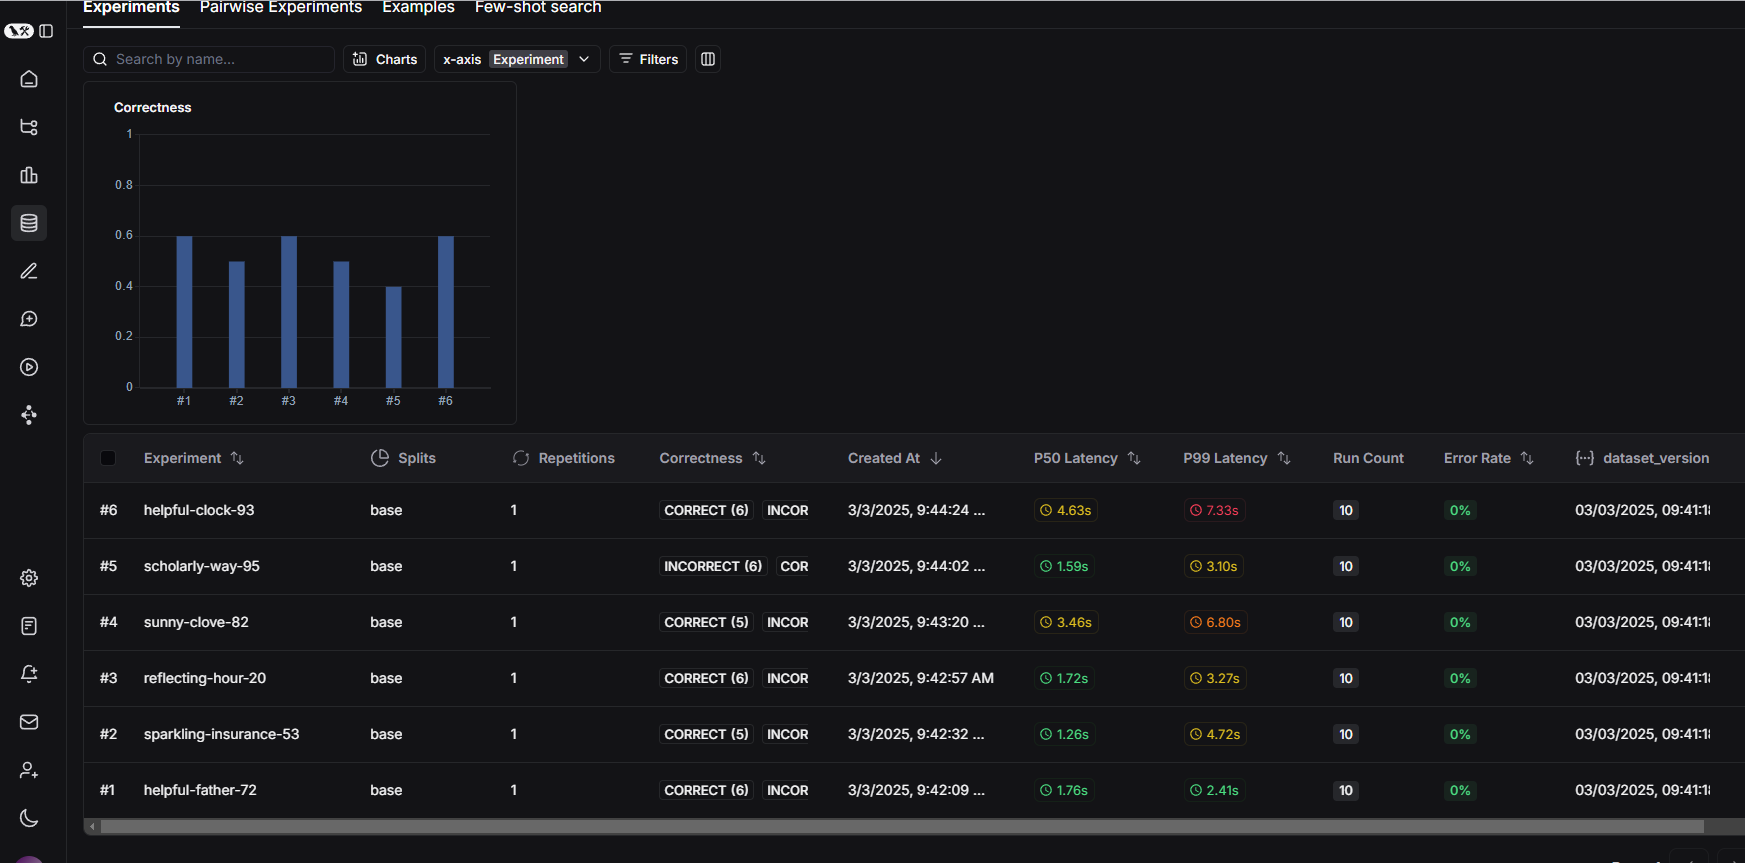

Based off the latency, error rates and correctness THe helpful-father-72 (which is the naive_retrieval_chain would be the one I would go with based off the results in Langsmith.)